In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

In [19]:
model = VGG16(weights='imagenet')

In [26]:
# image_path = "artifacts/cat_dog.jpeg"
image_path = "artifacts/Cat.jpg"
imgage = image.load_img(image_path, target_size=(224, 224))
img = np.expand_dims(imgage, axis=0)
img = preprocess_input(img)

In [27]:
predictions = model.predict(img)
decoded_predictions = decode_predictions(predictions, top=3)[0]
print(f"This image has a predictions of {decoded_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
This image has a predictions of [('n02124075', 'Egyptian_cat', 0.9579618), ('n02123045', 'tabby', 0.020875275), ('n02123159', 'tiger_cat', 0.014120069)]


In [28]:
predicted_class = np.argmax(predictions[0])

# Get the last convolutional layer
conv_layer = model.get_layer("block5_conv3")
grad_model = Model([model.inputs], [conv_layer.output, model.output])

In [29]:
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img)
    class_channel = predictions[:, predicted_class]

grads = tape.gradient(class_channel, conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = conv_output[0] @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

----------------

C:\Users\enay9\AppData\Local\Temp\ipykernel_19772\3887532047.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.8].


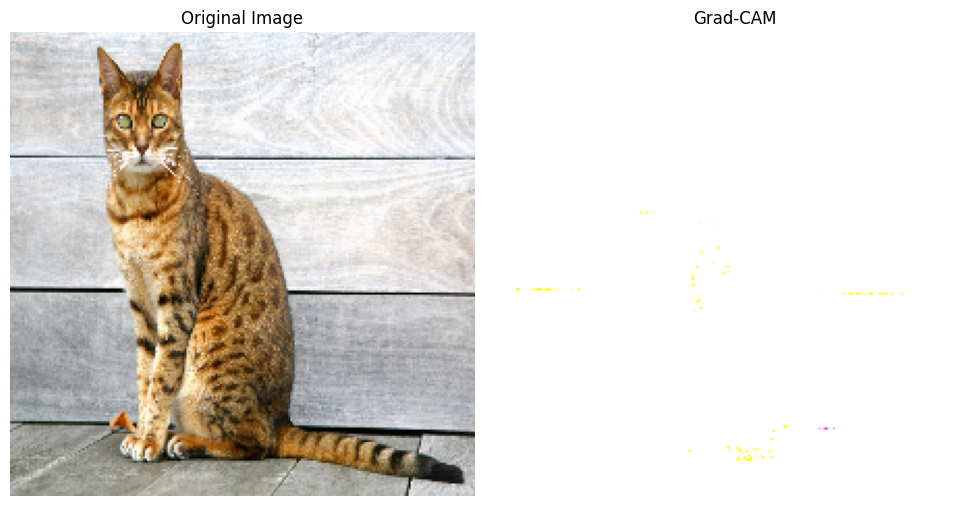

In [30]:
heatmap = np.uint8(255 * heatmap)
jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img = image.img_to_array(imgage)
heatmap = np.uint8(255 * heatmap)
jet = plt.cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.array_to_img(img))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()